In [1]:
from gc import callbacks
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as pyplot

# pip install tensorflow the first time 
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import expand_dims, cast, float32
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model



## 1. Create TensoBoard Session

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/
# define the log to tensorboard
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)



In [3]:
def print_image(image, array_bool):
    '''print images. 
       If array bool True: convert the array to an image
    '''
    if array_bool:
        pyplot.imshow(array_to_img(image))
    else:
        pyplot.imshow(image)
    pyplot.show()

In [4]:
def augment_data(aug_size, classes, base_path):
    '''Augments images. Takes as many pictures from each class as defined in aug_size and duplicates them.'''
    # define the duplication model
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2)])
    # iterate over the three classes
    for target in classes:
        files = os.listdir(os.path.join(base_path, target))
        # duplicate as many images as defined in aug_size
        for file in files[:aug_size[target]]:
            img = load_img(os.path.join(base_path, target, file), color_mode='rgb')
            img_cast = cast(expand_dims(img, 0), float32)
            img_aug_vec = data_augmentation(img_cast)
            img_aug = array_to_img(img_aug_vec[0])
            img_aug.save(os.path.join(base_path, target,file[:-4] + "_aug.png"), format="png")
        


## 2. Augment the image data

In [5]:
# augment the images in the train folders
run_code = False
if run_code:
    # load the files
    num_classes = 3
    input_shape = (224, 224, 3)
    base_path = '../imageclassifier-main/data/'
    classes = ['bottle', 'glasses', 'pen']
    aug_size = {'bottle': 130, 'glasses': 130, 'pen': 100}
    augment_data(aug_size, classes, base_path)


## 3. load the image data and train test split

In [6]:
run_code = True
if run_code:
    num_classes = 3
    input_shape = (224, 224, 3)
    base_path = '../imageclassifier-main/data/'
    x_train, y_train, x_test, y_test = [], [], [], []
    classes = ['bottle', 'glasses', 'pen']
    classes_test = ['bottle_test', 'glasses_test', 'pen_test']
    
    # load train images
    for target in classes:
        # get a list of all image files in the directory
        files = os.listdir(os.path.join(base_path, target))
        # load images and append them to x_train and y_train
        for file in files:
            img = load_img(os.path.join(base_path, target, file), color_mode='rgb')
            x_train.append(img_to_array(img))
            y_train.append(classes.index(target))
    
    # load test images
    for target in classes_test:
        # get a list of all image files in the directory
        files = os.listdir(os.path.join(base_path, target))
        # load images and append them to x_train and y_train
        for file in files:
            img = load_img(os.path.join(base_path, target, file), color_mode='rgb')
            x_test.append(img_to_array(img))
            y_test.append(classes_test.index(target))
    
    # change the list to a numpy array
    X_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1, 1)
    

FileNotFoundError: [Errno 2] No such file or directory: '../imageclassifier-main/data/bottle'

In [ ]:
# shuffle the train and test data
shuffler_train = np.random.permutation(len(X_train))
shuffler_test = np.random.permutation(len(X_test))

X_train = X_train[shuffler_train]
y_train = y_train[shuffler_train]

X_test = X_test[shuffler_test]
y_test = y_test[shuffler_test]


In [ ]:
# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# change y to categorical values
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(636, 224, 224, 3) (90, 224, 224, 3) (636, 3) (90, 3)


## 4. Create and fit CNN model

In [ ]:
# clear the last session
K.clear_session

# define the keras model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(filters=32, 
                        kernel_size=(5, 5), 
                        activation="relu",     
                        kernel_initializer=initializers.RandomNormal(stddev=1),
                        bias_initializer=initializers.Zeros()),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation="relu",
                        kernel_initializer=initializers.RandomNormal(stddev=1),
                        bias_initializer=initializers.Zeros()),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# model summary table
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 110, 110, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)            

In [ ]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', # the metrics we are monitoring
    min_delta=0.0005, # minimum metrics change. Else training will be stopped after no of patience perdiods
    patience=3, # number of epochs in which less than min delta is tolerated before stopping the training
    verbose=1, # 0: no messages, 1: message when something happens
)

In [ ]:
rc = True
if rc:
    # define the batch size and number of epochs
    batch_size = 20
    epochs = 20

    # complile and define eval metric
    model.compile(loss="categorical_crossentropy", 
                    optimizer="adam", 
                    metrics=["accuracy"])

    # fit the model
    hist = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks=[tensorboard_callback]) #early_stop

    # evaluate the model and print the results
    score = model.evaluate(X_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

Epoch 1/20
29/29 [==============================] - 31s 975ms/step - loss: 1.4650 - accuracy: 0.8549 - val_loss: 109.7394 - val_accuracy: 0.2656
Epoch 2/20
29/29 [==============================] - 24s 801ms/step - loss: 0.3989 - accuracy: 0.9580 - val_loss: 23.7604 - val_accuracy: 0.3438
Epoch 3/20
29/29 [==============================] - 21s 741ms/step - loss: 0.2590 - accuracy: 0.9738 - val_loss: 3.9246 - val_accuracy: 0.7500
Epoch 4/20
29/29 [==============================] - 21s 736ms/step - loss: 0.1589 - accuracy: 0.9738 - val_loss: 1.8531 - val_accuracy: 0.9219
Epoch 5/20
29/29 [==============================] - 22s 758ms/step - loss: 0.0970 - accuracy: 0.9860 - val_loss: 1.4490 - val_accuracy: 0.9062
Epoch 6/20
29/29 [==============================] - 21s 739ms/step - loss: 0.2703 - accuracy: 0.9685 - val_loss: 2.5111 - val_accuracy: 0.8750
Epoch 7/20
29/29 [==============================] - 21s 732ms/step - loss: 0.1432 - accuracy: 0.9790 - val_loss: 3.7820 - val_accuracy: 0.8

## 5. predict test data and plot results

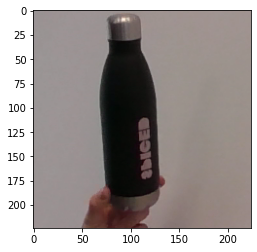

bottle  --->  predicted: bottle  [1.000000e+00 6.561006e-18 0.000000e+00]


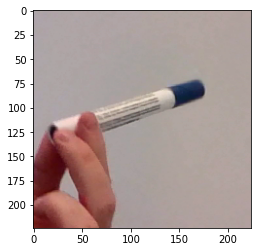

pen  --->  predicted: pen  [2.5722429e-23 3.8980637e-25 1.0000000e+00]


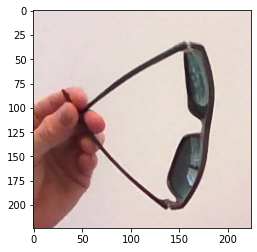

glasses  --->  predicted: glasses  [0. 1. 0.]


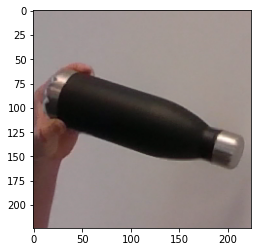

bottle  --->  predicted: bottle  [1.0000000e+00 3.1939607e-24 0.0000000e+00]


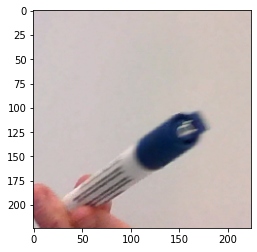

pen  --->  predicted: pen  [4.7848720e-13 1.5841878e-22 1.0000000e+00]


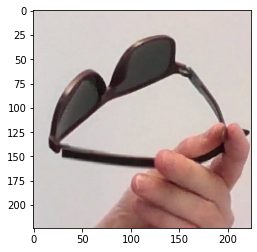

glasses  --->  predicted: glasses  [3.0978515e-26 1.0000000e+00 0.0000000e+00]


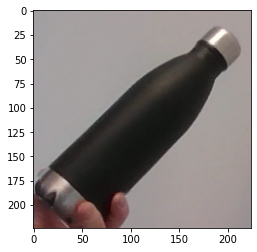

bottle  --->  predicted: bottle  [9.8269743e-01 1.7302528e-02 4.8596218e-24]


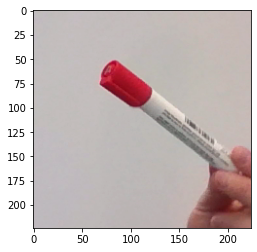

pen  --->  predicted: pen  [1.8317674e-31 1.1647915e-30 1.0000000e+00]


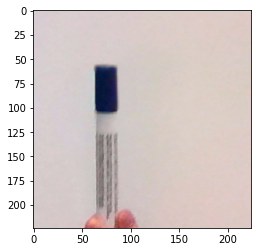

pen  --->  predicted: pen  [5.8724634e-13 1.2945925e-26 1.0000000e+00]


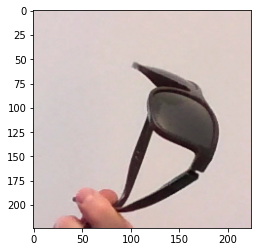

glasses  --->  predicted: glasses  [0. 1. 0.]


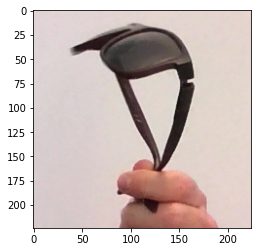

glasses  --->  predicted: glasses  [1.0576956e-35 1.0000000e+00 0.0000000e+00]


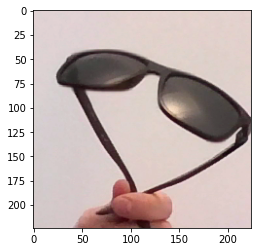

glasses  --->  predicted: glasses  [0. 1. 0.]


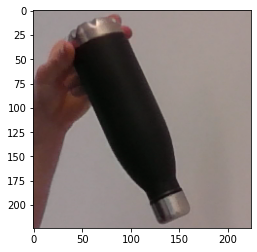

bottle  --->  predicted: bottle  [1.000000e+00 6.603669e-10 0.000000e+00]


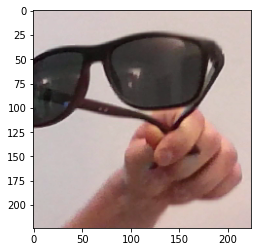

glasses  --->  predicted: glasses  [2.563063e-17 1.000000e+00 0.000000e+00]


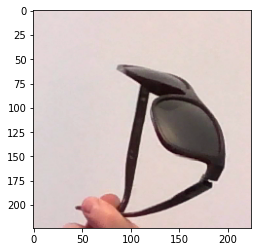

glasses  --->  predicted: glasses  [0. 1. 0.]


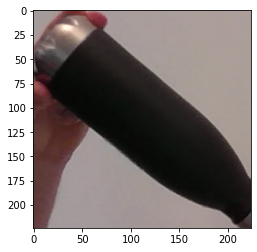

bottle  --->  predicted: bottle  [1.0000000e+00 1.0003894e-37 0.0000000e+00]


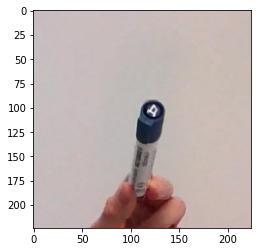

pen  --->  predicted: pen  [2.8297062e-22 3.1983930e-20 1.0000000e+00]


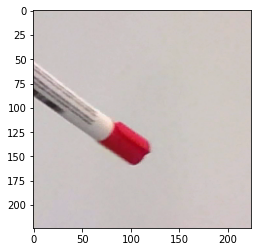

pen  --->  predicted: pen  [3.945604e-27 0.000000e+00 1.000000e+00]


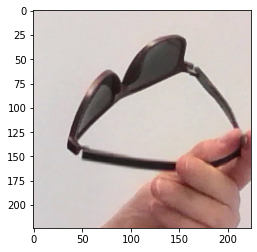

glasses  --->  predicted: glasses  [3.8269445e-17 1.0000000e+00 2.0394908e-37]


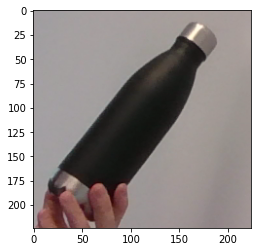

bottle  --->  predicted: bottle  [9.9807042e-01 1.9295500e-03 1.1869624e-29]


In [28]:
# predict the test data
prediction = model.predict(
    X_test,
    batch_size=None,
    verbose='auto',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)
# plot the images and print with the prediction
images = [array_to_img(array) for array in X_test]        
for image, y_predict, y_test in zip(images[:20], prediction[:20], y_test[:20]):
    pyplot.imshow(image)
    pyplot.show()
    print(f"{classes[np.argmax(y_test)]}  --->  predicted: {classes[np.argmax(y_predict)]}  {np.round(y_predict, 3)}")

<AxesSubplot:>

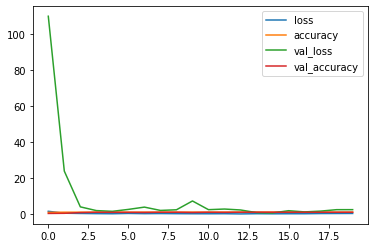

In [29]:
# Plot training accuracy and loss:
pd.DataFrame(hist.history).plot()

In [30]:
# save the mode
model.save("model_3.h5")

In [31]:
# show the analytic data on tensorboard
# %tensorboard --logdir logs/fit
%tensorboard --load_fast=false --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 7835), started 5:12:42 ago. (Use '!kill 7835' to kill it.)